In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

In [4]:
from torch.utils.data import DataLoader, Dataset, TensorDataset


In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

In [6]:
# Load D_ITEMS and D_LABITEMS as DataFrames
chart_items = pd.read_csv("data/D_ITEMS.csv.gz", low_memory=False)
chart_items.columns = chart_items.columns.str.lower()

In [7]:
chartevents = pd.read_csv('data/CHARTEVENTS.csv.gz', nrows=5000000, low_memory=False)
chartevents.columns = chartevents.columns.str.lower()

In [8]:
chartevents.head()

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,788,36,165660,241249.0,223834,2134-05-12 12:00:00,2134-05-12 13:56:00,17525.0,15.00,15.00,L/min,0,0,NaN,NaN
1,789,36,165660,241249.0,223835,2134-05-12 12:00:00,2134-05-12 13:56:00,17525.0,100.00,100.00,NaN,0,0,NaN,NaN
2,790,36,165660,241249.0,224328,2134-05-12 12:00:00,2134-05-12 12:18:00,20823.0,0.37,0.37,NaN,0,0,NaN,NaN
3,791,36,165660,241249.0,224329,2134-05-12 12:00:00,2134-05-12 12:19:00,20823.0,6.00,6.00,min,0,0,NaN,NaN
4,792,36,165660,241249.0,224330,2134-05-12 12:00:00,2134-05-12 12:19:00,20823.0,2.50,2.50,NaN,0,0,NaN,NaN


In [9]:
lab_events = pd.read_csv('data/LABEVENTS.csv.gz')
lab_events.columns = lab_events.columns.str.lower()
lab_items = pd.read_csv('data/D_LABITEMS.csv.gz')
lab_items.columns = lab_items.columns.str.lower()
display(lab_events.head())
display(lab_items.head())

,row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal


,row_id,itemid,label,fluid,category,loinc_code
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN


In [10]:

# Filter for relevant items in D_ITEMS
vital_signs_keywords = ['Heart Rate', 'Respiratory Rate', 
                           'Non Invasive Blood Pressure mean', 'Arterial Blood Pressure mean',
                         'Temperature Celsius', 
                           'SpO2', 'SaO2']
vital_sign_itemids = chart_items[chart_items["label"].isin(vital_signs_keywords)][["itemid", "label"]]

# Filter for relevant lab tests in D_LABITEMS
lab_tests_keywords = ['Lactate', 'WBC', 'Platelet Count']
lab_test_itemids = lab_items[lab_items["label"].isin(lab_tests_keywords)][["itemid", "label"]]

print("Vital sign itemids:", vital_sign_itemids)
print("Lab test itemids:", lab_test_itemids)

Vital sign itemids:        itemid                             label
263       618                  Respiratory Rate
475       211                        Heart Rate
749       834                              SaO2
1418      646                              SpO2
11498  220045                        Heart Rate
11504  220052      Arterial Blood Pressure mean
11522  220181  Non Invasive Blood Pressure mean
11524  220210                  Respiratory Rate
12367  223762               Temperature Celsius
Lab test itemids:      itemid           label
140   50813         Lactate
591   51265  Platelet Count
715   51516             WBC


In [11]:
# Filter chartevents for relevant vital signs and ensure `value` is numeric
chartevents_filtered = chartevents[chartevents["itemid"].isin(vital_sign_itemids["itemid"])]
chartevents_filtered["value"] = pd.to_numeric(chartevents_filtered["value"], errors='coerce')

# Filter labevents for relevant lab tests and ensure `value` is numeric
labevents_filtered = lab_events[lab_events["itemid"].isin(lab_test_itemids["itemid"])]
labevents_filtered["value"] = pd.to_numeric(labevents_filtered["value"], errors='coerce')

/var/folders/yd/zfmh4dwx4_sg32mk5g_gy5vh0000gn/T/ipykernel_62836/406330552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chartevents_filtered["value"] = pd.to_numeric(chartevents_filtered["value"], errors='coerce')
/var/folders/yd/zfmh4dwx4_sg32mk5g_gy5vh0000gn/T/ipykernel_62836/406330552.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labevents_filtered["value"] = pd.to_numeric(labevents_filtered["value"], errors='coerce')


In [12]:
# Merge with itemid to label mapping for chartevents
chartevents_filtered = pd.merge(chartevents_filtered, vital_sign_itemids, on="itemid", how="left")

# Merge with itemid to label mapping for labevents
labevents_filtered = pd.merge(labevents_filtered, lab_test_itemids, on="itemid", how="left")

In [13]:
chartevents_pivot = chartevents_filtered.pivot_table(index=["subject_id", "charttime"], columns="label", values="value", aggfunc="mean").reset_index()
labevents_pivot = labevents_filtered.pivot_table(index=["subject_id", "charttime"], columns="label", values="value", aggfunc="mean").reset_index()

In [14]:
display(chartevents_pivot.head())
display(labevents_pivot.head())

label,subject_id,charttime,Arterial Blood Pressure mean,Heart Rate,Non Invasive Blood Pressure mean,Respiratory Rate,Temperature Celsius
0,23,2157-10-21 12:06:00,NaN,77.0,NaN,14.0,NaN
1,23,2157-10-21 12:08:00,NaN,75.0,NaN,NaN,NaN
2,23,2157-10-21 13:00:00,86.0,84.0,NaN,18.0,NaN
3,23,2157-10-21 14:00:00,86.0,78.0,NaN,11.0,NaN
4,23,2157-10-21 15:00:00,98.0,81.0,NaN,13.0,NaN


label,subject_id,charttime,Lactate,Platelet Count,WBC
0,2,2138-07-17 20:48:00,NaN,5.0,NaN
1,2,2138-07-17 21:10:00,NaN,302.0,NaN
2,3,2101-10-04 15:24:00,NaN,261.0,NaN
3,3,2101-10-05 06:00:00,NaN,246.0,NaN
4,3,2101-10-06 05:45:00,NaN,301.0,NaN


In [15]:
# Ensure charttime is in datetime format
chartevents_pivot["charttime"] = pd.to_datetime(chartevents_pivot["charttime"])
labevents_pivot["charttime"] = pd.to_datetime(labevents_pivot["charttime"])

# Sort the filtered tables by subject_id and charttime
chartevents_pivot = chartevents_pivot.sort_values(by=["subject_id", "charttime"])
labevents_pivot = labevents_pivot.sort_values(by=["subject_id", "charttime"])


In [16]:
print(chartevents_pivot.head())
print(labevents_pivot.head())

label  subject_id           charttime  Arterial Blood Pressure mean  \
0              23 2157-10-21 12:06:00                           NaN   
1              23 2157-10-21 12:08:00                           NaN   
2              23 2157-10-21 13:00:00                          86.0   
3              23 2157-10-21 14:00:00                          86.0   
4              23 2157-10-21 15:00:00                          98.0   

label  Heart Rate  Non Invasive Blood Pressure mean  Respiratory Rate  \
0            77.0                               NaN              14.0   
1            75.0                               NaN               NaN   
2            84.0                               NaN              18.0   
3            78.0                               NaN              11.0   
4            81.0                               NaN              13.0   

label  Temperature Celsius  
0                      NaN  
1                      NaN  
2                      NaN  
3                 

In [17]:
patients = pd.read_csv('data/PATIENTS.csv.gz')
patients.columns = patients.columns.str.lower()

In [18]:
patients

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
46515,31840,44089,M,2026-05-25 00:00:00,NaN,NaN,NaN,0
46516,31841,44115,F,2124-07-27 00:00:00,NaN,NaN,NaN,0
46517,31842,44123,F,2049-11-26 00:00:00,2135-01-12 00:00:00,2135-01-12 00:00:00,NaN,1
46518,31843,44126,F,2076-07-25 00:00:00,NaN,NaN,NaN,0


In [19]:
admissions = pd.read_csv('data/ADMISSIONS.csv.gz')
admissions.columns = admissions.columns.str.lower()

In [20]:
diagnoses = pd.read_csv('data/DIAGNOSES_ICD.csv.gz')
diagnoses.columns = diagnoses.columns.str.lower()
diagnoses_labels = pd.read_csv('data/D_ICD_DIAGNOSES.csv.gz')
diagnoses_labels.columns = diagnoses_labels.columns.str.lower()

In [21]:
icustays = pd.read_csv('data/ICUSTAYS.csv.gz')
icustays.columns = icustays.columns.str.lower()

In [22]:
display(patients.info())
display(admissions.info())
display(icustays.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   row_id       46520 non-null  int64 
 1   subject_id   46520 non-null  int64 
 2   gender       46520 non-null  object
 3   dob          46520 non-null  object
 4   dod          15759 non-null  object
 5   dod_hosp     9974 non-null   object
 6   dod_ssn      13378 non-null  object
 7   expire_flag  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   row_id                58976 non-null  int64 
 1   subject_id            58976 non-null  int64 
 2   hadm_id               58976 non-null  int64 
 3   admittime             58976 non-null  object
 4   dischtime             58976 non-null  object
 5   deathtime             5854 non-null   object
 6   admission_type        58976 non-null  object
 7   admission_location    58976 non-null  object
 8   discharge_location    58976 non-null  object
 9   insurance             58976 non-null  object
 10  language              33644 non-null  object
 11  religion              58518 non-null  object
 12  marital_status        48848 non-null  object
 13  ethnicity             58976 non-null  object
 14  edregtime             30877 non-null  object
 15  edouttime             30877 non-null

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          61532 non-null  int64  
 1   subject_id      61532 non-null  int64  
 2   hadm_id         61532 non-null  int64  
 3   icustay_id      61532 non-null  int64  
 4   dbsource        61532 non-null  object 
 5   first_careunit  61532 non-null  object 
 6   last_careunit   61532 non-null  object 
 7   first_wardid    61532 non-null  int64  
 8   last_wardid     61532 non-null  int64  
 9   intime          61532 non-null  object 
 10  outtime         61522 non-null  object 
 11  los             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


None

In [23]:
def calculate_age(dob, admittime):
    """Calculate age at the time of admission."""
    age = admittime.year - dob.year - ((admittime.month, admittime.day) < (dob.month, dob.day))
    return age

In [24]:
def prep_demographics_data(patients, admissions, icustays):
    # Merge patients and admissions on `subject_id`
    patients_admissions = pd.merge(patients, admissions, on="subject_id", how="inner")
    
    # Calculate age at admission
    patients_admissions["admittime"] = pd.to_datetime(patients_admissions["admittime"])
    patients_admissions["dob"] = pd.to_datetime(patients_admissions["dob"])
    patients_admissions["age"] = patients_admissions.apply(lambda row: calculate_age(row["dob"], row["admittime"]), axis=1)
    
    # Merge the result with icustays on `subject_id` and `hadm_id`
    demographics = pd.merge(patients_admissions, icustays, on=["subject_id", "hadm_id"], how="inner")

    # Filter for relevant columns
    demographics = demographics[[
        "subject_id", "gender", "age", "ethnicity", "admission_type",
        "admittime", "dischtime", "intime", "outtime", "first_careunit"
    ]]

    # Convert all time-related columns to datetime
    time_cols = ["admittime", "dischtime", "intime", "outtime"]
    for col in time_cols:
        demographics[col] = pd.to_datetime(demographics[col])
    
    # Fill missing gender or age with placeholders (example)
    demographics["gender"] = demographics["gender"].fillna("Unknown")
    demographics["age"] = demographics["age"].fillna(demographics["age"].mean())

    return demographics

In [25]:
demographics = prep_demographics_data(patients, admissions, icustays)

In [62]:
demographics.head()

,subject_id,gender,age,ethnicity,admission_type,admittime,dischtime,intime,outtime,first_careunit
0,249,F,74,WHITE,EMERGENCY,2149-12-17 20:41:00,2149-12-31 14:55:00,2149-12-18 20:06:02,2149-12-24 13:31:45,TSICU
1,249,F,79,WHITE,EMERGENCY,2155-02-03 20:16:00,2155-02-14 11:15:00,2155-02-03 20:17:29,2155-02-05 18:34:02,MICU
2,249,F,79,WHITE,EMERGENCY,2155-02-03 20:16:00,2155-02-14 11:15:00,2155-02-07 18:51:16,2155-02-11 16:00:39,TSICU
3,249,F,81,WHITE,EMERGENCY,2156-04-27 15:33:00,2156-05-14 15:30:00,2156-05-01 18:10:12,2156-05-03 18:43:45,MICU
4,249,F,81,WHITE,EMERGENCY,2156-04-27 15:33:00,2156-05-14 15:30:00,2156-05-10 17:47:35,2156-05-11 19:16:03,MICU


In [63]:
notes = pd.read_csv('data/NOTEEVENTS.csv.gz', low_memory=False)
notes.columns = notes.columns.str.lower()

In [64]:
notes.head()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [65]:
notes_simple = notes[["subject_id", "chartdate","charttime", "text"]]

In [66]:

# Step 1: Identify duplicates
duplicates = notes_simple.groupby(["subject_id", "chartdate"]).filter(lambda x: len(x) > 1)

# Step 2: Create a DataFrame with examples of duplicates
duplicate_examples = duplicates.sort_values(by=["subject_id", "chartdate"])

In [67]:
notes_simple[notes_simple["subject_id"] == 3]

,subject_id,chartdate,charttime,text
48470,3,2101-10-31,NaN,Admission Date: [**2101-10-20**] Discharg...
94503,3,2101-10-21,NaN,PATIENT/TEST INFORMATION:\nIndication: S/P Car...
94504,3,2101-10-21,NaN,PATIENT/TEST INFORMATION:\nIndication: Pericar...
94775,3,2101-10-21,NaN,PATIENT/TEST INFORMATION:\nIndication: Left ve...
291192,3,2102-01-26,NaN,Sinus rhythm. A-V conduction delay. Slight Q-T...
...,...,...,...,...
1299236,3,2101-10-22,2101-10-22 04:36:00,Resp. Care Note\nPt intubated and vented on se...
1299452,3,2101-10-24,2101-10-24 05:53:00,MICU NPN 7PM-7AM:\nNeuro: Pt is sleeping most ...
1299453,3,2101-10-24,2101-10-24 17:00:00,"npn 7-7p\n\nneuro: Pt is alert, follows comman..."
1299654,3,2101-10-26,2101-10-26 05:40:00,MICU NPN 7P-7A\nNEURO: SLEPT WELL WHEN NOT COU...


In [68]:
notes_simple[notes_simple["subject_id"] == 249]

,subject_id,chartdate,charttime,text
53729,249,2149-12-31,NaN,Admission Date: [**2149-12-17**] ...
54095,249,2155-02-14,NaN,Admission Date: [**2155-2-3**] D...
54096,249,2156-05-14,NaN,Admission Date: [**2156-4-27**] ...
99261,249,2149-12-19,NaN,PATIENT/TEST INFORMATION:\nIndication: Chronic...
107794,249,2155-09-16,NaN,PATIENT/TEST INFORMATION:\nIndication: Coronar...
...,...,...,...,...
1261418,249,2149-12-22,2149-12-22 04:31:00,NEURO: Alert and follows commands. +MAE noted....
1261419,249,2149-12-22,2149-12-22 04:31:00,Pt with RR 3-6 when placed on CPAP...will reat...
1261420,249,2149-12-22,2149-12-22 05:58:00,Respiratory Care\nPt remains intubated and ven...
1261421,249,2149-12-22,2149-12-22 06:25:00,Please see above.\n


In [69]:
notes_simple["chartdate"] = pd.to_datetime(notes_simple["chartdate"])
# notes_simple["charttime"] = pd.to_datetime(notes_simple["charttime"])


# Step 1: Fill NaN `charttime` with `chartdate` and set time to noon
notes_simple["charttime"] = notes_simple.apply(
    lambda row: row["chartdate"].replace(hour=12, minute=0, second=0) if pd.isna(row["charttime"]) else row["charttime"],
    axis=1
)

# Step 2: Concatenate `text` for duplicate `subject_id` and `charttime`
# Group by `subject_id` and `charttime`, then concatenate the `text` column
notes_simple = notes_simple.groupby(["subject_id", "charttime"], as_index=False).agg({
    "text": lambda x: " ".join(x)  # Concatenate texts for duplicates
})

print(notes_simple[notes_simple["charttime"].isna()])  # Check rows where charttime is still NaT
print(notes_simple.dtypes)  # Check column types to confirm `charttime` is datetime

/var/folders/yd/zfmh4dwx4_sg32mk5g_gy5vh0000gn/T/ipykernel_62836/1164591979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notes_simple["chartdate"] = pd.to_datetime(notes_simple["chartdate"])
/var/folders/yd/zfmh4dwx4_sg32mk5g_gy5vh0000gn/T/ipykernel_62836/1164591979.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notes_simple["charttime"] = notes_simple.apply(


Empty DataFrame
Columns: [subject_id, charttime, text]
Index: []
subject_id     int64
charttime     object
text          object
dtype: object


In [70]:
# Display the processed DataFrame
print(notes_simple)

         subject_id            charttime  \
0                 2  2138-07-17 22:51:00   
1                 2  2138-07-17 23:08:00   
2                 3  2101-10-06 12:00:00   
3                 3  2101-10-11 12:00:00   
4                 3  2101-10-12 12:00:00   
...             ...                  ...   
1726489       99999  2117-12-31 14:04:00   
1726490       99999  2117-12-31 17:39:00   
1726491       99999  2118-01-01 05:20:00   
1726492       99999  2118-01-01 05:32:00   
1726493       99999  2118-01-01 13:01:00   

                                                      text  
0        Neonatology Attending Triage Note\n\nBaby [**N...  
1        Nursing Transfer note\n\n\nPt admitted to NICU...  
2        Sinus rhythm\nInferior/lateral ST-T changes ar...  
3        Sinus rhythm\nA-V delay\nNonspecific inferior ...  
4        Sinus rhythm. Generalized low QRS voltage. Non...  
...                                                    ...  
1726489  Chief Complaint: Respiratory distre

In [71]:
# Step 1: Identify duplicates
duplicates = notes_simple.groupby(["subject_id", "charttime"]).filter(lambda x: len(x) > 1)

# Step 2: Create a DataFrame with examples of duplicates
duplicate_examples = duplicates.sort_values(by=["subject_id", "charttime"])

duplicate_examples

,subject_id,charttime,text


In [72]:
labs = pd.merge(lab_events, lab_items, on='itemid', how='left')

In [73]:
display(labs[labs["hadm_id"].notna() ].head())
display(admissions.head())

,row_id_x,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag,row_id_y,label,fluid,category,loinc_code
160,441,3,145834.0,50868,2101-10-20 16:40:00,17,17.0,mEq/L,NaN,69,Anion Gap,Blood,Chemistry,1863-0
161,442,3,145834.0,50882,2101-10-20 16:40:00,25,25.0,mEq/L,NaN,83,Bicarbonate,Blood,Chemistry,1963-8
162,443,3,145834.0,50893,2101-10-20 16:40:00,8.2,8.2,mg/dL,abnormal,94,"Calcium, Total",Blood,Chemistry,2000-8
163,444,3,145834.0,50902,2101-10-20 16:40:00,99,99.0,mEq/L,abnormal,103,Chloride,Blood,Chemistry,2075-0
164,445,3,145834.0,50910,2101-10-20 16:40:00,48,48.0,IU/L,NaN,111,Creatine Kinase (CK),Blood,Chemistry,2157-6


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [74]:
# Step 1: Filter and Organize Data
# Select the Relevant Tests:

# Use test_name to filter for a specific lab test or vital sign (e.g., "heart rate").

# If multiple tests are relevant, you could process them separately or as multivariate time series.

# Group By Patient and Admission:

# Use person_id and admission_id to group the data by individual patients and their ICU stays.

# Sort by Time:

# Ensure the charttime column is sorted within each group to maintain temporal order.

# Step 2: Handle Missing and Inconsistent Data
# Interpolate or impute missing values in the value column.

# Normalize the value column to bring all values into a similar range (e.g., [0, 1] or standard scaling).

# Step 3: Create Time Series Sequences
# You need to generate sliding windows of sequences for each group. Each sequence will represent input features for the model, and the next value in the sequence will be the prediction target.

In [75]:
def top_10_frequent(df, column_name):
  return df[column_name].value_counts().nlargest(10)

In [76]:
display(top_10_frequent(labs,"label"))
info = pd.DataFrame(top_10_frequent(labs,"label"))
display(info.columns)
display(labs.head())

label
Glucose           1046912
Hematocrit         881769
Potassium          845739
Hemoglobin         842156
Sodium             808401
Creatinine         797389
Chloride           795480
Urea Nitrogen      791838
Bicarbonate        780648
Platelet Count     778365
Name: count, dtype: int64

Index(['count'], dtype='object')

,row_id_x,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag,row_id_y,label,fluid,category,loinc_code
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN,21,pH,Blood,Blood Gas,11558-4
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN,1,SPECIMEN TYPE,BLOOD,BLOOD GAS,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN,3,Base Excess,Blood,Blood Gas,11555-0
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN,5,Calculated Total CO2,Blood,Blood Gas,34728-6
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal,9,Free Calcium,Blood,Blood Gas,1994-3


In [77]:
labs.describe()

,row_id_x,subject_id,hadm_id,itemid,valuenum,row_id_y
count,2.785406e+07,2.785406e+07,2.224503e+07,2.785406e+07,2.493284e+07,2.785406e+07
mean,1.395852e+07,3.146391e+04,1.499675e+05,5.106214e+04,7.853220e+01,2.626678e+02
std,8.057287e+06,2.714177e+04,2.886231e+04,2.092624e+02,5.512982e+03,2.088147e+02
min,1.000000e+00,2.000000e+00,1.000010e+05,5.080000e+04,-4.140000e+02,1.000000e+00
25%,6.980364e+06,1.120500e+04,1.251080e+05,5.088200e+04,4.400000e+00,8.300000e+01
50%,1.396099e+07,2.258500e+04,1.498490e+05,5.098300e+04,1.820000e+01,1.840000e+02
75%,2.093829e+07,4.790600e+04,1.750200e+05,5.125000e+04,6.000000e+01,4.500000e+02
max,2.790765e+07,9.999900e+04,1.999990e+05,5.155500e+04,1.427200e+07,7.530000e+02


In [78]:
labs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27854055 entries, 0 to 27854054
Data columns (total 14 columns):
 #   Column      Dtype  
---  ------      -----  
 0   row_id_x    int64  
 1   subject_id  int64  
 2   hadm_id     float64
 3   itemid      int64  
 4   charttime   object 
 5   value       object 
 6   valuenum    float64
 7   valueuom    object 
 8   flag        object 
 9   row_id_y    int64  
 10  label       object 
 11  fluid       object 
 12  category    object 
 13  loinc_code  object 
dtypes: float64(2), int64(4), object(8)
memory usage: 2.9+ GB


In [79]:
labs[(labs["label"] == "Chloride") & (labs["valuenum"].isna())]

,row_id_x,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag,row_id_y,label,fluid,category,loinc_code
63003,66167,117,164853.0,50902,2133-11-22 03:00:00,ERROR,NaN,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0
655597,654057,997,163287.0,50902,2107-01-24 15:40:00,GREATER THAN 140,NaN,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0
1380676,1330679,2112,186165.0,50902,2164-12-17 12:00:00,QNS TO PERFORM TEST,NaN,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0
1443550,1590285,2476,NaN,50902,2147-05-30 16:00:00,ERROR,NaN,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0
1621744,1652693,2580,NaN,50902,2175-12-28 14:50:00,"DISREGARD PREVIOUS RESULT 96,SPECIMEN MISLABELLED",NaN,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23798692,24133244,70954,130133.0,50902,2144-12-03 19:06:00,"ERROR, CONTAMINATED SPECIMEN",NaN,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0
27263482,26849803,91954,162776.0,50902,2190-01-30 18:55:00,GREATER THAN 140,NaN,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0
27273152,26849856,91954,162776.0,50902,2190-01-31 03:47:00,GREATER THAN 140,NaN,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0
27273181,26849885,91954,162776.0,50902,2190-01-31 13:32:00,GREATER THAN 140,NaN,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0


In [80]:
len(labs)

27854055

In [81]:
# Define the LSTM Model
class VitalSignLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VitalSignLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

In [82]:
# Example: Preprocessing
def preprocess_dataframe(df, test_name, sequence_length):
    # Filter the relevant test
    df = df[df["label"] == test_name]
    
    #Remove rows with NaN or Inf in the 'value' column
    df = df[~df["valuenum"].isna()]
    df = df[np.isfinite(df["valuenum"])]
    
    # Sort by patient, admission, and time
    df = df.sort_values(by=["subject_id", "hadm_id", "charttime"])
    
    # Normalize the 'value' column
    df["valuenum"] = (df["valuenum"] - df["valuenum"].min()) / (df["valuenum"].max() - df["valuenum"].min())
    
    # Create sequences
    sequences = []
    for _, group in df.groupby(["subject_id", "hadm_id"]):
        values = group["valuenum"].values
        if len(values) > sequence_length:  # Ensure enough data points
            for i in range(len(values) - sequence_length):
                sequences.append(values[i:i + sequence_length + 1])  # Input sequence + target value
    
    sequences = np.array(sequences)
    X = sequences[:, :-1]  # Input sequence
    y = sequences[:, -1]   # Target value
    return X, y

In [83]:
# Setup data
sequence_length = 5
X, y = preprocess_dataframe(labs, test_name="Chloride", sequence_length=sequence_length)

In [84]:
display(X)
display(y)

array([[0.57894737, 0.66917293, 0.66917293, 0.66165414, 0.66917293],
       [0.66917293, 0.66917293, 0.66165414, 0.66917293, 0.67669173],
       [0.66917293, 0.66165414, 0.66917293, 0.67669173, 0.66917293],
       ...,
       [0.68421053, 0.69172932, 0.68421053, 0.66917293, 0.65413534],
       [0.69172932, 0.68421053, 0.66917293, 0.65413534, 0.65413534],
       [0.68421053, 0.66917293, 0.65413534, 0.65413534, 0.63909774]])

array([0.67669173, 0.66917293, 0.66165414, ..., 0.65413534, 0.63909774,
       0.64661654])

In [85]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (317304, 5), Testing data shape: (79327, 5)


In [86]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [87]:
# Recap of the Workflow
# Filter and preprocess the data: Handle missing values, normalize, and create sequences.

# Train-test split: Divide the sequences into training and testing datasets.

# Prepare for PyTorch: Convert to tensors and create DataLoader objects for model training.

# This process transforms your dataframe into a format that's ready to be used by your LSTM model. If you'd like, I can also help you integrate this preprocessing into the LSTM training pipeline!

In [88]:
# Initialize the model
input_size = X_train.shape[1]  # Number of features in each time step
hidden_size = 64
num_layers = 2
output_size = 1  # Predict a single value

model = VitalSignLSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [89]:
# Training function
def train_notes_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs = inputs.unsqueeze(-1)  # Add a feature dimension
            labels = labels.unsqueeze(-1)  # Add a feature dimension

            # Check for invalid inputs
            if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                print("NaN or Inf detected in inputs!")
                continue

            optimizer.zero_grad()
            outputs = model(inputs)

            # Check for invalid outputs
            if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                print("NaN or Inf detected in outputs!")
                continue

            loss = criterion(outputs, labels)

            # Check for invalid loss
            if torch.isnan(loss) or torch.isinf(loss):
                print("NaN or Inf detected in loss!")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")

In [90]:
# Evaluation function
def evaluate_notes_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(-1)  # Add a feature dimension
            labels = labels.unsqueeze(-1)  # Add a feature dimension
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    print(f"Evaluation Loss: {total_loss / len(test_loader)}")

In [91]:
# Train and evaluate the model
train_notes_model(model, train_loader, criterion, optimizer, epochs=5)
evaluate_notes_model(model, test_loader, criterion)

Epoch 1/5, Loss: 0.0028347823039356476
Epoch 2/5, Loss: 0.0005006438125047442
Epoch 3/5, Loss: 0.0004490880312871744
Epoch 4/5, Loss: 0.00044618320641640367
Epoch 5/5, Loss: 0.00044398211966656474
Evaluation Loss: 0.00043589136232028385


In [56]:
# Explanation
# Preprocessing:

# Filters the relevant lab test based on test_name.

# Sorts by charttime to ensure temporal consistency.

# Normalizes value to bring it into a [0, 1] range.

# Creates sequences of length sequence_length for LSTM input.

# Train-Test Split:

# Splits the sequences into training and testing datasets.

# PyTorch Preparation:

# Converts data into tensors and uses DataLoader for batch processing.

# Training and Evaluation:

# Trains the LSTM model using the training DataLoader.

# Evaluates the model on the test DataLoader and prints the loss.

# This integrated pipeline takes your raw dataframe, processes it, and trains an LSTM model to predict vital sign trends. Let me know if you’d like additional features or refinements!

In [92]:
# Function to visualize predictions
def visualize_all_predictions(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(-1)  # Add a feature dimension
            outputs = model(inputs)
            predictions.extend(outputs.squeeze(-1).numpy())  # Remove extra dimensions
            actuals.extend(labels.numpy())
    
    # Convert lists to NumPy arrays for plotting
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Plot predictions vs actuals
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label="Actual Values", marker="o", linestyle="-", color="blue")
    plt.plot(predictions, label="Predicted Values", marker="x", linestyle="--", color="red")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.title("Predicted vs Actual Values")
    plt.legend()
    plt.show()

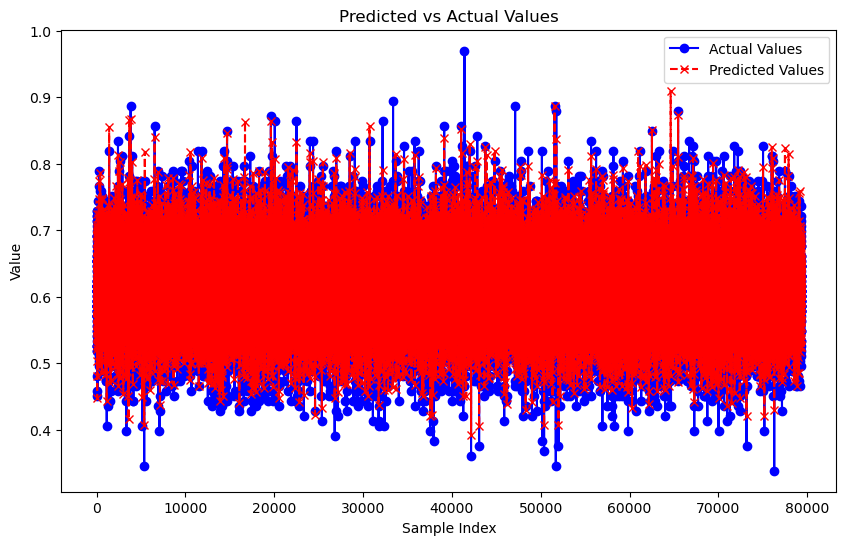

In [93]:
# Call the function to visualize predictions
visualize_all_predictions(model, test_loader)

In [94]:


# Function to visualize closest and furthest predictions
def visualize_predictions(model, test_loader, percentile=10):
    model.eval()
    predictions = []
    actuals = []
    
    # Collect predictions and actual values
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(-1)  # Add a feature dimension
            outputs = model(inputs)
            predictions.extend(outputs.squeeze(-1).numpy())  # Remove extra dimensions
            actuals.extend(labels.numpy())
    
    # Convert to NumPy arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate absolute errors
    errors = np.abs(predictions - actuals)
    
    # Find indices for closest and furthest predictions
    num_samples = len(errors)
    num_visualize = max(1, int(percentile / 100 * num_samples))  # 10% of the data
    
    closest_indices = np.argsort(errors)[:num_visualize]
    furthest_indices = np.argsort(errors)[-num_visualize:]
    
    # Plot 10% closest predictions
    plt.figure(figsize=(10, 6))
    plt.plot(actuals[closest_indices], label="Actual Values", marker="o", linestyle="-", color="blue")
    plt.plot(predictions[closest_indices], label="Predicted Values", marker="x", linestyle="--", color="green")
    plt.xlabel("Sample Index (Closest Predictions)")
    plt.ylabel("Value")
    plt.title(f"{percentile}% Closest Predictions")
    plt.legend()
    plt.show()
    
    # Plot 10% furthest-off predictions
    plt.figure(figsize=(10, 6))
    plt.plot(actuals[furthest_indices], label="Actual Values", marker="o", linestyle="-", color="blue")
    plt.plot(predictions[furthest_indices], label="Predicted Values", marker="x", linestyle="--", color="red")
    plt.xlabel("Sample Index (Furthest Predictions)")
    plt.ylabel("Value")
    plt.title(f"{percentile}% Furthest-Off Predictions")
    plt.legend()
    plt.show()


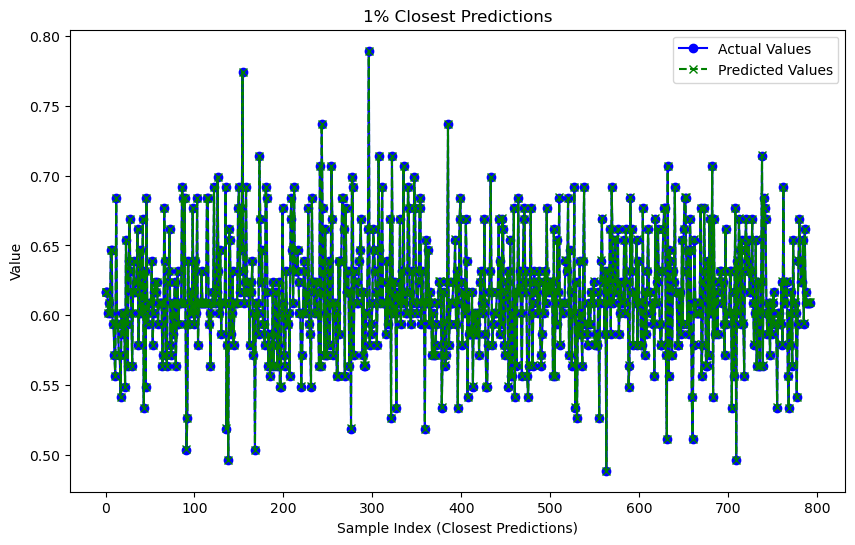

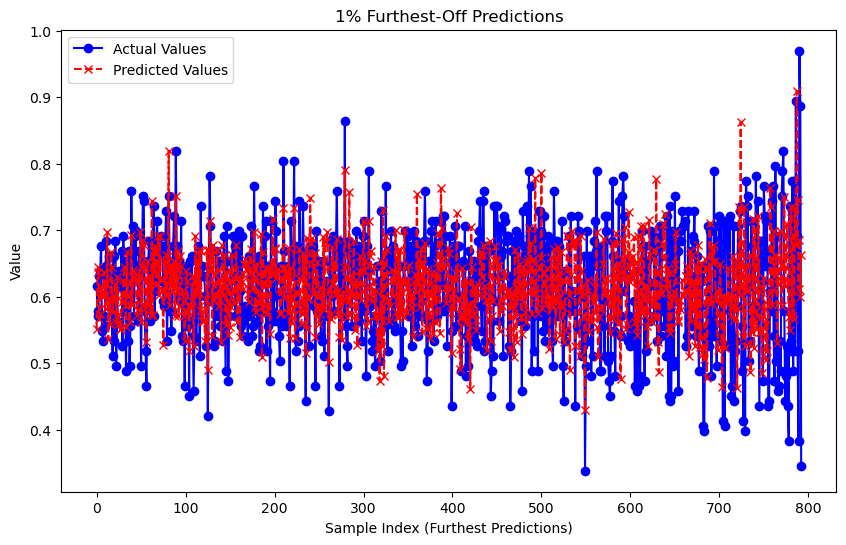

In [95]:
visualize_predictions(model, test_loader, 1)

In [30]:
# Define the Sepsis Prediction Model
class SepsisPredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, static_input_size, output_size):
        super(SepsisPredictionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size + static_input_size, 8)
        self.fc2 = nn.Linear(8, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_time, x_static):
        lstm_out, _ = self.lstm(x_time)
        lstm_last = lstm_out[:, -1, :]  # Last time step
        combined = torch.cat((lstm_last, x_static), dim=1)
        out = self.fc1(combined)
        out = self.fc2(out)
        return self.sigmoid(out)  # Ensure sigmoid activation here

In [43]:
# Smaller model for debugging
class SimpleSepsisPredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, static_input_size, output_size):
        super(SimpleSepsisPredictionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + static_input_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_time, x_static):
        lstm_out, _ = self.lstm(x_time)
        lstm_last = lstm_out[:, -1, :]  # Last time step
        combined = torch.cat((lstm_last, x_static), dim=1)
        out = self.fc(combined)
        return self.sigmoid(out)

In [44]:
def generate_sepsis_labels(merged_data):
    # Define sepsis criteria (example)
    lactate_threshold = 2.0
    wbc_threshold = [4, 12]  # WBC count below 4 or above 12
    hr_threshold = 100  # Heart rate above 100

    # Initialize sepsis label column
    merged_data['sepsis_label'] = 0

    # Apply criteria to determine sepsis cases
    merged_data.loc[merged_data['Lactate'] > lactate_threshold, 'sepsis_label'] = 1
    merged_data.loc[(merged_data['WBC'] < wbc_threshold[0]) | 
                    (merged_data['WBC'] > wbc_threshold[1]), 'sepsis_label'] = 1
    merged_data.loc[merged_data['Heart Rate'] > hr_threshold, 'sepsis_label'] = 1

    return merged_data

In [47]:

def preprocess_data(chartevents, labevents, demographics, sequence_length):
    # Merge chartevents and labevents on subject_id and charttime
    merged_data = pd.merge(chartevents, labevents, on=['subject_id', 'charttime'], how='outer')
    merged_data = pd.merge(merged_data, demographics, on='subject_id', how='left')
    merged_data = merged_data.sort_values(by=['subject_id', 'charttime'])

    # Ensure columns used for normalization are numeric
    for col in merged_data.columns:
        if col not in ['subject_id', 'charttime', 'sepsis_label'] and merged_data[col].dtype == object:
            merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

    # Normalize features
    for col in merged_data.columns:
        if col not in ['subject_id', 'charttime', 'sepsis_label']:
            merged_data[col] = (merged_data[col] - merged_data[col].min()) / (merged_data[col].max() - merged_data[col].min())
            merged_data[col].fillna(0, inplace=True)

    # Generate and add sepsis labels
    merged_data = generate_sepsis_labels(merged_data)
    
    # Example vital_signs and lab_tests for the sake of completeness
    # vital_signs = ['Heart Rate', 'Respiratory Rate', 'Mean Blood Pressure', 'Temperature', 'Oxygen Saturation']
    # lab_tests = ['Lactate', 'White Blood Cell Count', 'Platelet Count']
    vital_signs = ['Heart Rate', 'Respiratory Rate']
    lab_tests = ['Lactate', 'WBC', 'Platelet Count']

    # Create sequences
    sequences, static_features, labels = [], [], []
    for _, group in merged_data.groupby('subject_id'):
        values = group[vital_signs + lab_tests].values
        static = group[['age', 'gender']].iloc[0].values  # Example static features
        label = group['sepsis_label'].iloc[-1]  # Sepsis label for the sequence
        if len(values) > sequence_length:
            for i in range(len(values) - sequence_length):
                sequences.append(values[i:i + sequence_length])
                static_features.append(static)
                labels.append(label)

    return np.array(sequences), np.array(static_features), np.array(labels)


In [48]:
# Preprocess the data
sequence_length = 5
X_time, X_static, y = preprocess_data(chartevents_pivot, labevents_pivot, demographics, sequence_length)

/var/folders/yd/zfmh4dwx4_sg32mk5g_gy5vh0000gn/T/ipykernel_62836/65731717.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data[col].fillna(0, inplace=True)


In [49]:
# Train-Test Split
X_time_train, X_time_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_time, X_static, y, test_size=0.4, random_state=42)

In [50]:
# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_time_train, dtype=torch.float32),
                              torch.tensor(X_static_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_time_test, dtype=torch.float32),
                             torch.tensor(X_static_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.float32))

In [51]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [52]:
# Model Initialization
# Example Data (Replace with your actual preprocessed data)
input_size = X_time.shape[2]  # Number of features per time step
hidden_size = 2
num_layers = 2
static_input_size = X_static.shape[1]  # Number of static features
output_size = 1  # Binary classification

In [53]:

import torch.optim as optim
# Initialize the model
model = SimpleSepsisPredictionModel(input_size, hidden_size, num_layers, static_input_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [60]:
# Training function
def train_sepsis_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_time_batch, X_static_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_time_batch, X_static_batch)
            
            # Debugging: Print outputs and y_batch values
            # print("Outputs: ", outputs)
            # print("Targets: ", y_batch)

            # Ensure target values are between 0 and 1

            # Ensure outputs are squeezed correctly
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            elif outputs.dim() == 2:
                outputs = outputs.view(-1)

            # print(f"Outputs shape after squeezing: {outputs.shape}")
            
            # Compute loss
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")

In [58]:
# Evaluation function
def evaluate_sepsis_model(model, test_loader):
    model.eval()
    all_outputs, all_labels = [], []
    with torch.no_grad():
        for X_time_batch, X_static_batch, y_batch in test_loader:
            outputs = model(X_time_batch, X_static_batch).squeeze()
            all_outputs.extend(outputs.numpy())
            all_labels.extend(y_batch.numpy())
    auc = roc_auc_score(all_labels, all_outputs)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, (np.array(all_outputs) > 0.5).astype(int), average='binary')
    print(f"AUROC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

In [61]:
# Train and Evaluate
# Train the model
train_sepsis_model(model, train_loader, criterion, optimizer, epochs=1)

Epoch 1/1, Loss: 0.0


In [ ]:
evaluate_sepsis_model(model, test_loader)

In [96]:
from medspacy.ner import TargetMatcher, TargetRule
from spacy.language import Language
import medspacy

In [97]:
# Load the medspaCy NLP pipeline
nlp = medspacy.load()

In [98]:
# Define a factory to register the TargetMatcher
@Language.factory("target_matcher")
def create_target_matcher(nlp, name):
    target_matcher = TargetMatcher(nlp)  # Initialize the TargetMatcher
    # Add rules for identifying sentiment
    rules = [
        TargetRule("stable", "POSITIVE_SENTIMENT"),
        TargetRule("improving", "POSITIVE_SENTIMENT"),
        TargetRule("critical", "NEGATIVE_SENTIMENT"),
        TargetRule("deteriorating", "NEGATIVE_SENTIMENT"),
    ]
    target_matcher.add(rules)
    return target_matcher

In [99]:


# Load a pre-trained sentiment analysis model (e.g., SST-2 fine-tuned BERT)
tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-SST-2")

# Function to calculate sentiment score
def get_sentiment_score(note):
    inputs = tokenizer(note, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    probabilities = softmax(outputs.logits, dim=1)
    positive_score = probabilities[0][1].item()  # Positive sentiment score
    return positive_score

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [100]:
# Add the registered TargetMatcher to the NLP pipeline
nlp.add_pipe("target_matcher")

In [101]:
# Test the pipeline on example text
example_text = "Patient is stable but deteriorating rapidly."
doc = nlp(example_text)

In [102]:
# Display extracted entities and their labels
print("Entities and Labels:")
for ent in doc.ents:
    print(f"{ent.text}: {ent.label_}")

Entities and Labels:
stable: POSITIVE_SENTIMENT
deteriorating: NEGATIVE_SENTIMENT


In [103]:
# Step 1: Count the number of notes per subject
note_counts = notes_simple["subject_id"].value_counts()

# Step 2: Get the top 50 subjects with the most notes
top_100_subjects = note_counts.head(50).index.tolist()

# Step 3: Filter the DataFrame to include only rows with those subjects
subset_notes = notes_simple[notes_simple["subject_id"].isin(top_100_subjects)]

# Display the filtered subset
print(subset_notes)

         subject_id            charttime  \
4019            109  2137-11-04 12:00:00   
4020            109  2137-11-05 12:00:00   
4021            109  2137-11-06 12:00:00   
4022            109  2137-11-07 12:00:00   
4023            109  2137-11-14 12:00:00   
...             ...                  ...   
1580689       78076  2115-02-18 08:02:00   
1580690       78076  2115-03-01 20:21:00   
1580691       78076  2115-03-01 20:50:00   
1580692       78076  2115-06-10 09:20:00   
1580693       78076  2115-06-10 17:01:00   

                                                      text  
4019     Sinus rhythm. Probable left ventricular hypert...  
4020     Sinus rhythm. Probable left ventricular hypert...  
4021     PATIENT/TEST INFORMATION:\nIndication: Murmur....  
4022     Sinus rhythm at upper limits of normal rate. C...  
4023     Sinus rhythm\nLeft ventricular hypertrophy\nNo...  
...                                                    ...  
1580689  [**2115-2-18**] 8:02 AM\n US HEMATO

In [104]:
notes_data = subset_notes

In [105]:

# Annotate each note with medspaCy
def annotate_sentiment(note):
    doc = nlp(note)
    sentiment = None
    for ent in doc.ents:
        if ent.label_ in ["POSITIVE_SENTIMENT", "NEGATIVE_SENTIMENT"]:
            sentiment = ent.label_
    return sentiment if sentiment else "NEUTRAL"

In [106]:
len(notes_data)

40354

In [107]:
# Apply sentiment analysis
notes_data["sentiment"] = notes_data["text"].apply(annotate_sentiment)

In [108]:
# Visualization 1: Patients with Most Notes
def plot_patient_note_counts(data):
    counts = data["subject_id"].value_counts()
    plt.figure(figsize=(8, 5))
    counts.plot(kind="bar", color="skyblue")
    plt.xlabel("Patient ID")
    plt.ylabel("Number of Notes")
    plt.title("Patients with Most Discharge Notes")
    plt.show()

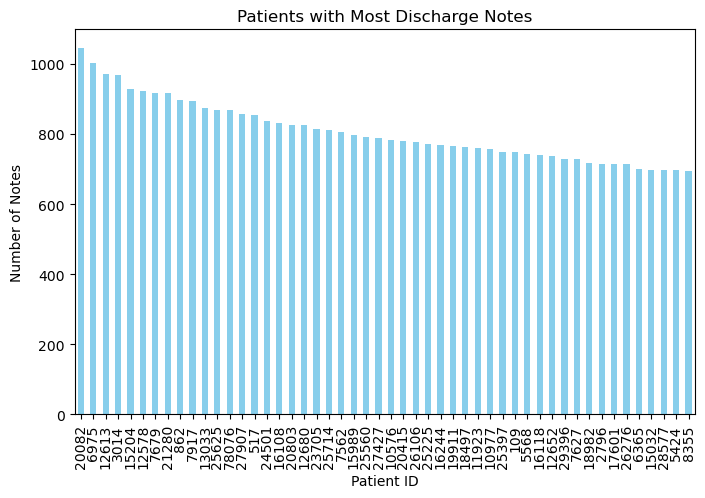

In [109]:
plot_patient_note_counts(notes_data)

In [125]:
# Visualization 2: Sentiment Over Time
def plot_sentiment_over_time(data):
    plt.figure(figsize=(10, 6))

    # Ensure 'charttime' is converted to datetime
    data['charttime'] = pd.to_datetime(data['charttime'])

    # Define the desired order for sentiment categories
    sentiment_order = ['NEGATIVE_SENTIMENT', 'NEUTRAL', 'POSITIVE_SENTIMENT']
    sentiment_mapping = {sentiment: idx for idx, sentiment in enumerate(sentiment_order)}
    data['sentiment_mapped'] = data['sentiment'].map(sentiment_mapping)

    for patient_id, group in data.groupby("subject_id"):
        group = group.sort_values("charttime")
        plt.plot(group["charttime"], group["sentiment_mapped"], marker="o", label=f"Patient {patient_id}")

    plt.xlabel("Time")
    plt.ylabel("Sentiment")
    plt.title("Sentiment Over Time by Patient")
    plt.legend()

    # Set custom y-ticks and labels
    plt.yticks(ticks=[0, 1, 2], labels=sentiment_order)
    
    plt.show()

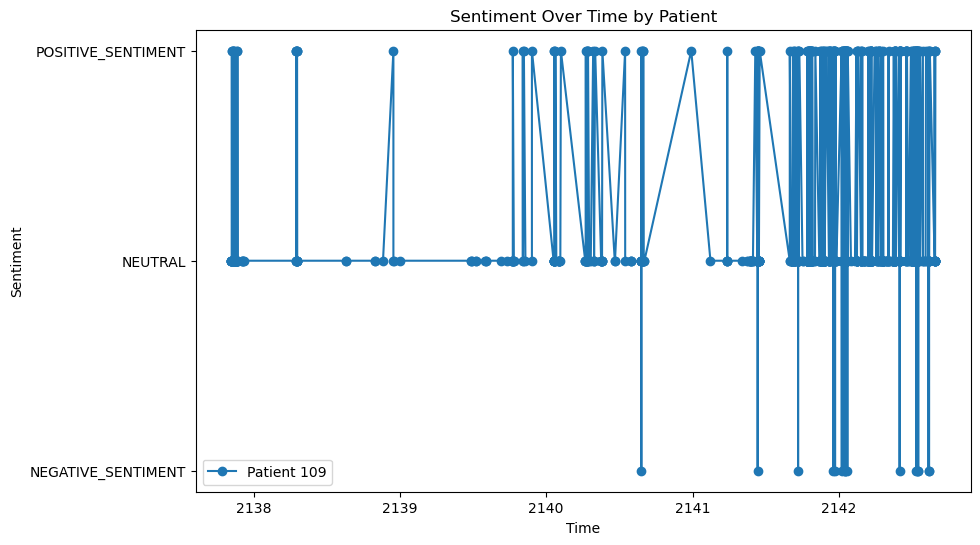

In [126]:
plot_sentiment_over_time(notes_data[notes_data["subject_id"] == 109])

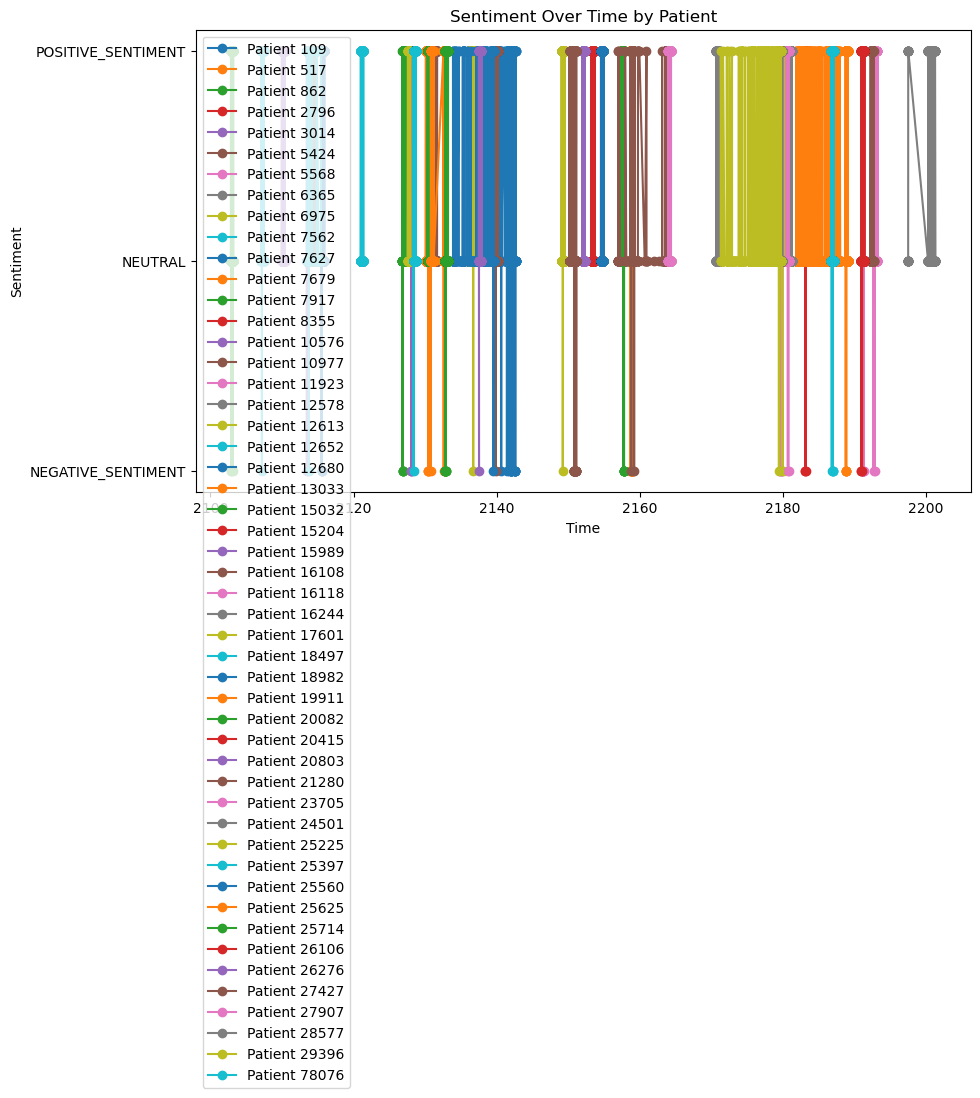

In [127]:
plot_sentiment_over_time(notes_data)

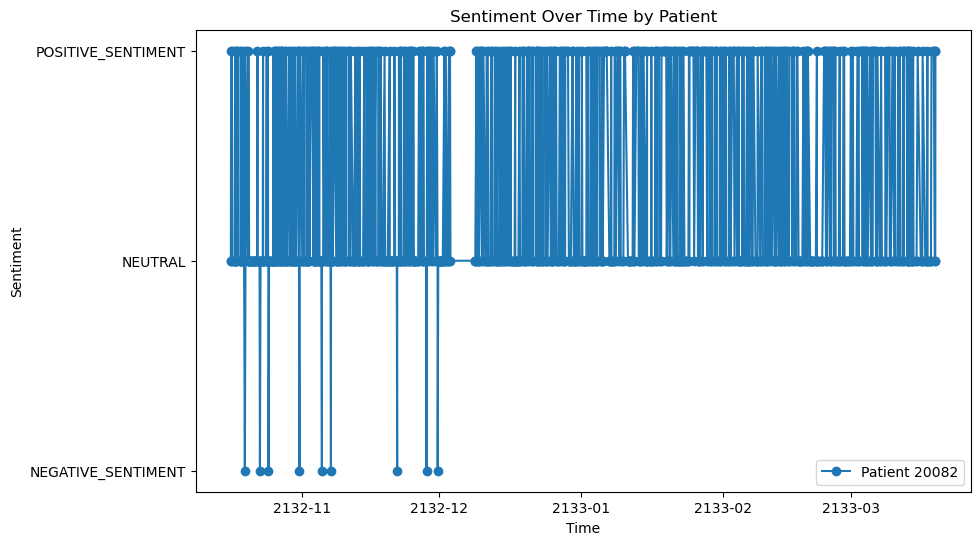

In [128]:
plot_sentiment_over_time(notes_data[notes_data["subject_id"] == 20082])